## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

## Read in cleaned df

In [2]:
df = pd.read_pickle("outputs/df_cleaned.pickle")

In [3]:
# Up-sampling minority label
df_majority = df[df["label"] == 0]
df_minority = df[df["label"] == 1]

df_minority_upsampled = resample(
    df_majority,
    replace=True,
    n_samples=df_majority.count()[0],
    random_state=42
)

df_upsampled = pd.concat(
    [df_majority, df_minority_upsampled]
)

In [4]:
# Replace wit df_upsampled
features = df.iloc[:, :-1]
response = df.iloc[:, -1]
le = LabelEncoder().fit(response)
features_scaled = StandardScaler().fit_transform(features)
response_tf = le.transform(response)

## Training and Testing set splits

In [5]:
X_train, x_test, y_train, y_test = train_test_split(
    features_scaled,
    response_tf,
    test_size=0.2,
    random_state=42
)

## Classifier

In [6]:
# Let's implement K-Fold CV

model = GradientBoostingClassifier()
kfold = StratifiedKFold(
    n_splits=10, 
    random_state=42
)
results = cross_val_score(
    model, 
    features_scaled, 
    response_tf, 
    cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 77.95% (0.58%)


## Validation

In [7]:
model.fit(X_train, y_train)
pred = model.predict(x_test)

In [8]:
score = model.score(x_test, y_test)

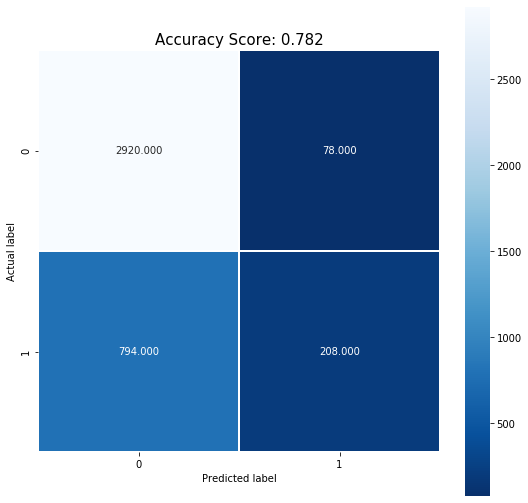

In [9]:
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15);

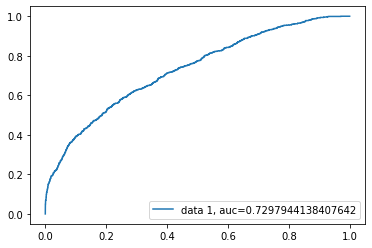

In [10]:
# First iteration

y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [11]:
# Feature importances
feature_importance = pd.DataFrame(
    list(
        zip(features.columns, model.feature_importances_)
    )
)
feature_importance.columns = ["feature", "score"]
feature_importance.sort_values("score", ascending=False)

,feature,score
0,second,0.496608
13,std_acc,0.093393
4,max_speed,0.046201
2,Speed,0.046049
33,bearing_90,0.041175
7,speed_30,0.040319
1,distance_covered,0.032753
25,gyro_90,0.028762
8,speed_70,0.027459
21,std_gyro,0.016610


## Grid Search

In [12]:
parameters = {
    "n_estimators": [10, 50, 100, 200],
    "learning_rate": [0.5, 0.25, 0.1, 0.05],
    "min_samples_split": [0.1, 0.5, 0.7],
    "min_samples_leaf": [0.1, 0.3],
    "max_depth":[3,5,8],
    #"max_features":["log2","sqrt"],
    #"subsample":[0.5, 0.8, 0.9, 1.0],
    }

In [13]:
clf = GridSearchCV(
    GradientBoostingClassifier(), 
    parameters, 
    cv=10, 
    n_jobs=-1
)

In [15]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.5, 0.25, 0.1, 0.05], 'min_samples_split': [0.1, 0.5, 0.7], 'min_samples_leaf': [0.1, 0.3], 'max_depth': [3, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
clf.score(X_train, y_train)

0.7778125

In [16]:
clf.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 100}